In [1]:
import os
os.chdir("/Users/layne/desktop/aiqc")

In [2]:
import aiqc
from aiqc import datum

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
aiqc.delete_db(confirm=True)


=> Success - deleted database file at path:
/Users/layne/Library/Application Support/aiqc/aiqc.sqlite3



In [4]:
aiqc.create_db()


=> Success - created database file at path:
/Users/layne/Library/Application Support/aiqc/aiqc.sqlite3


=> Success - created the following tables within database:
['algorithm', 'batch', 'dataset', 'encoderset', 'featurecoder', 'featureset', 'file', 'fold', 'foldset', 'hyperparamcombo', 'hyperparamset', 'image', 'job', 'jobset', 'label', 'labelcoder', 'result', 'splitset', 'tabular']



In [3]:
df = datum.to_pandas('sonar.csv')

In [4]:
df.head()

,a,b,c,d,e,f,g,h,i,j,...,az,ba,bb,bc,bd,be,bf,bg,bh,object
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
dataset = aiqc.Dataset.Tabular.from_pandas(dataframe=df)

In [6]:
label_col = 'object'

In [7]:
label = dataset.make_label(columns=[label_col])

In [8]:
featureset = dataset.make_featureset(exclude_columns=[label_col])

In [9]:
splitset = featureset.make_splitset(
    label_id = label.id
    , size_test = 0.15
)

In [10]:
foldset = splitset.make_foldset(fold_count=5)

Warning - The number of samples <176> in your training Split
is not evenly divisible by the `fold_count` <5> you specified.
This can result in misleading performance metrics for the last Fold.



In [11]:
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer

In [12]:
encoderset = splitset.make_encoderset()

In [13]:
labelcoder = encoderset.make_labelcoder(
    sklearn_preprocess = OrdinalEncoder()
)

In [14]:
featurecoder0 = encoderset.make_featurecoder(
    sklearn_preprocess = PowerTransformer(method='yeo-johnson', copy=False)
    , dtypes = ['float64']
)


__/ featurecoder_index: 0 \________
=> The column(s) below matched your filter(s) and were ran through a test-encoding successfully.
['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'aa',
 'ab',
 'ac',
 'ad',
 'ae',
 'af',
 'ag',
 'ah',
 'ai',
 'aj',
 'ak',
 'al',
 'am',
 'an',
 'ao',
 'ap',
 'aq',
 'ar',
 'as',
 'at',
 'au',
 'av',
 'aw',
 'ax',
 'ay',
 'az',
 'ba',
 'bb',
 'bc',
 'bd',
 'be',
 'bf',
 'bg',
 'bh']

=> Nice! Now all feature column(s) have encoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



In [15]:
def binary_model_build(input_shape, **hyperparameters):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout

    model = Sequential(name='Sonar')
    for l in range(hyperparameters['dense_layer_count']):
        model.add(Dense(hyperparameters['neuron_count'], input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(hyperparameters['dropout_rate']))

    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

Hyperparameters are extremely flexible. Not just library-specific arguments.

In [16]:
def binary_model_train(model, samples_train, samples_evaluate, **hyperparameters):
	from keras.callbacks import History

	model.fit(
	samples_train['features'], samples_train['labels']
		, validation_data = (samples_evaluate['features'], samples_evaluate['labels'])
		, verbose = 0
		, batch_size = 3
		, epochs = hyperparameters['epoch_count']
		, callbacks = [History()]
	)
	return model

In [17]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
    , analysis_type = "classification_binary"
    , function_model_build = binary_model_build
    , function_model_train = binary_model_train
)

In [52]:
hyperparameters = {
    "neuron_count": [6, 9, 12]
    , "dense_layer_count": [2]
    , "dropout_rate": [0.2]
    , "epoch_count": [50, 60, 70]
}

hyperparamset = algorithm.make_hyperparamset(hyperparameters)

In [53]:
batch = algorithm.make_batch(
    splitset_id = splitset.id
    , foldset_id = foldset.id
    , hyperparamset_id = hyperparamset.id
    , encoderset_id  = encoderset.id
    , repeat_count = 1
)

In [64]:
batch.run_jobs()


All jobs have been completed.



🔮 Training Models 🔮: 100%|██████████████████████████████████████| 45/45 [00:00<00:00, 1177.12it/s]


In [117]:
batch.metrics_to_pandas().tail(6)

,hyperparamcombo_id,jobset_id,fold_index,job_id,result_id,split,accuracy,f1,loss,precision,recall,roc_auc
129,29,29,3,144,134,test,0.906250,0.903226,0.515583,0.875000,0.933333,0.956863
130,29,29,3,144,134,folds_train_combined,0.985816,0.987500,0.039717,1.000000,0.975309,1.000000
131,29,29,3,144,134,fold_validation,0.800000,0.810811,0.668369,0.714286,0.937500,0.917763
132,29,29,4,145,135,test,0.937500,0.937500,0.481257,0.882353,1.000000,0.945098
133,29,29,4,145,135,folds_train_combined,1.000000,1.000000,0.018660,1.000000,1.000000,1.000000
134,29,29,4,145,135,fold_validation,0.800000,0.820513,0.815962,0.941176,0.727273,0.884615


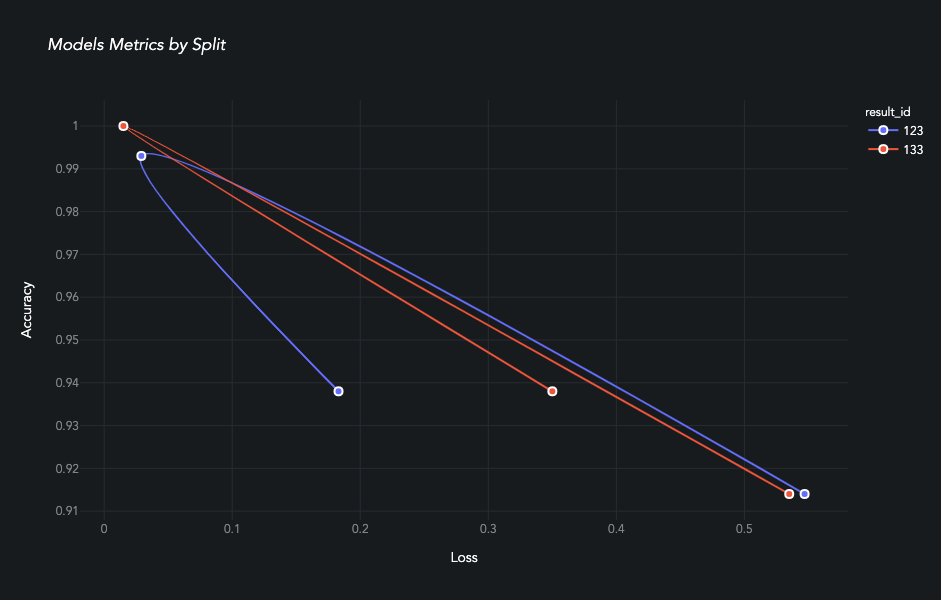

In [118]:
batch.plot_performance(max_loss=0.6, min_accuracy=0.88)

In [111]:
result = aiqc.Result.get_by_id(123)

In [104]:
result.job.hyperparamcombo.hyperparameters_to_pandas()

param,value
neuron_count,12.000000
dense_layer_count,2.000000
dropout_rate,0.200000
epoch_count,50.000000


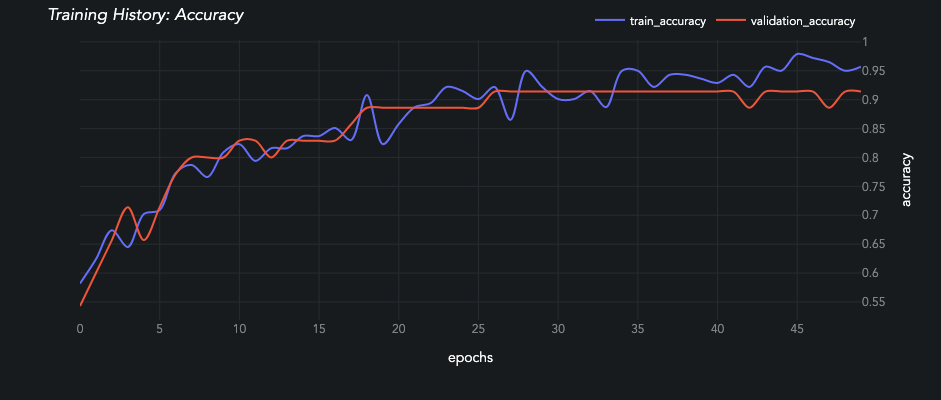

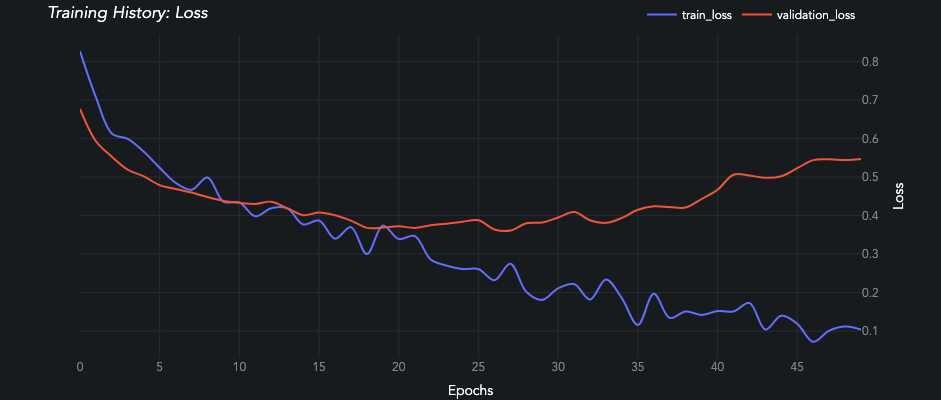

In [105]:
result.plot_learning_curve()

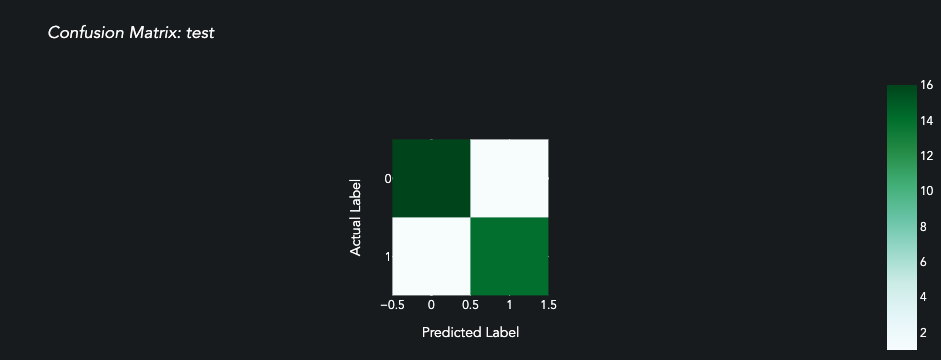

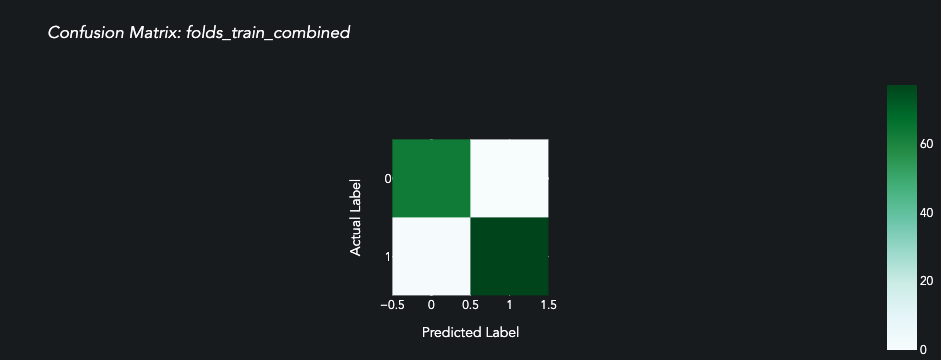

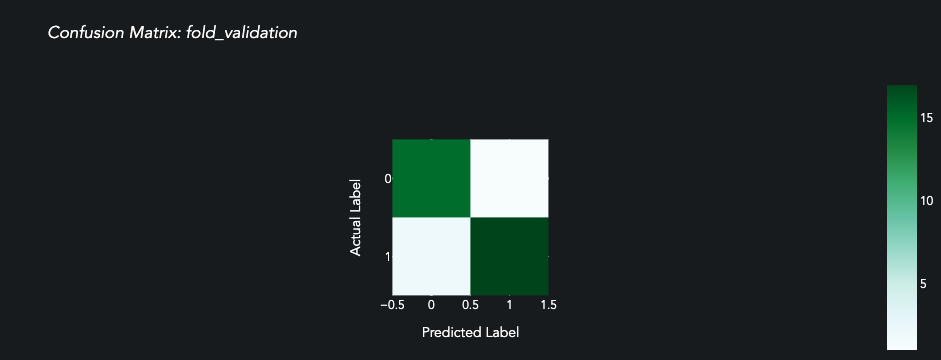

In [106]:
result.plot_confusion_matrix()

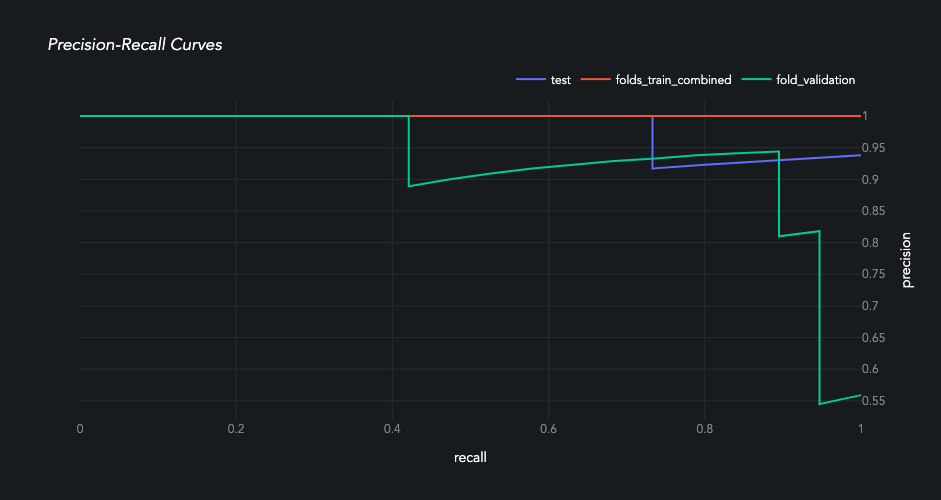

In [107]:
result.plot_precision_recall()

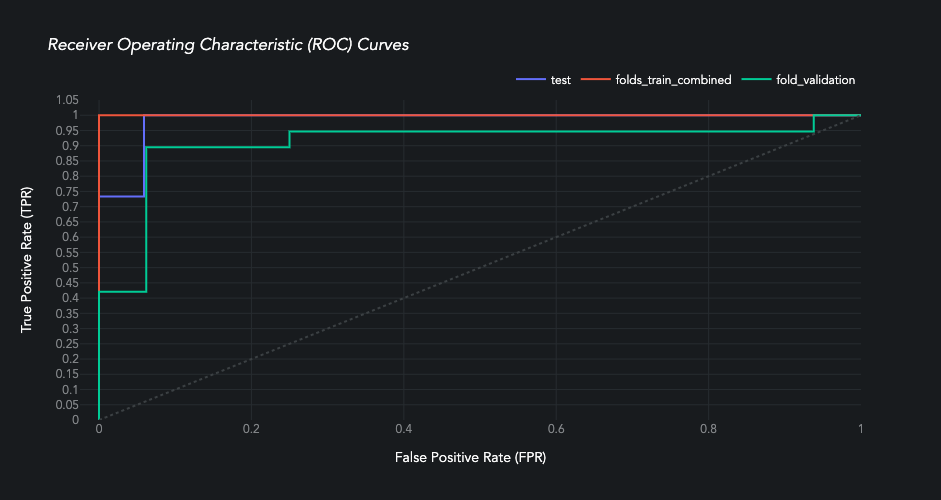

In [108]:
result.plot_roc_curve()

In [10]:
import pandas as pd

In [31]:
import aiqc
from aiqc import datum

In [32]:
df = datum.to_pandas('exoplanets.parquet')

In [33]:
df.dtypes

TypeFlag                  int64
PlanetaryMassJpt        float64
PeriodDays              float64
SurfaceTempK            float64
DistFromSunParsec       float64
HostStarMassSlrMass     float64
HostStarRadiusSlrRad    float64
HostStarMetallicity     float64
HostStarTempK           float64
dtype: object

In [34]:
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler

In [35]:
splitset = aiqc.Pipeline.Tabular.make(
    
    # Data source.
    dataFrame_or_filePath = file_path
    , dtype = None
    
    # Column selection.
    , label_column = 'SurfaceTempK'
    , features_excluded = None
    
    # Split/ fold strategy.
    , size_test = 0.24
    , size_validation = None # Folding instead.
    , fold_count = 7
    , bin_count = 4
    
    # Encoding strategy.
    , label_encoder = StandardScaler(copy=False)
    , feature_encoders = [
        {
            "sklearn_preprocess": PowerTransformer(method='yeo-johnson', copy=False), 
            "dtypes": ['float64']
        },
        {
            "sklearn_preprocess": OneHotEncoder(sparse=False),
            "columns": ['TypeFlag']
        }
    ]
)


___/ featurecoder_index: 0 \_________

=> The column(s) below matched your filter(s) and were ran through a test-encoding successfully.
['PlanetaryMassJpt',
 'PeriodDays',
 'DistFromSunParsec',
 'HostStarMassSlrMass',
 'HostStarRadiusSlrRad',
 'HostStarMetallicity',
 'HostStarTempK']

=> The remaining column(s) and dtype(s) can be used in downstream Featurecoder(s):
{'TypeFlag': 'int64'}


___/ featurecoder_index: 1 \_________

=> The column(s) below matched your filter(s) and were ran through a test-encoding successfully.
['TypeFlag']

=> Nice! Now all feature column(s) have encoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



In [36]:
splitset.samples.keys()

dict_keys(['train', 'test'])

In [37]:
splitset.foldsets[0].folds[0].samples.keys()

dict_keys(['folds_train_combined', 'fold_validation'])

In [38]:
splitset.to_pandas()['test']['features'].head(5)

,TypeFlag,PlanetaryMassJpt,PeriodDays,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarMetallicity,HostStarTempK
270,0,0.048758,5.736100,40.75,0.930,0.8800,0.35,5370.0
277,0,0.024700,15.299000,16.82,0.832,0.7821,-0.15,5075.0
389,0,0.917000,2.828042,1150.00,1.078,1.1160,0.16,5675.0
387,2,1.709000,2.204737,320.00,1.590,2.0200,0.32,6310.0
90,2,0.914000,2.152221,165.80,0.890,0.8400,-0.08,5255.0


In [39]:
splitset.foldsets[0].to_numpy()[0]['fold_validation']['labels'][:10]

array([[1590. ],
       [ 372.6],
       [1519.5],
       [ 846.5],
       [1149.1],
       [1776. ],
       [ 135.5],
       [ 200.2],
       [ 220. ],
       [1812. ]])